# Virtual Branching for Person Re-ID

In [1]:
import numpy as np
np.set_printoptions(threshold=1000)

import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.callbacks import LearningRateScheduler, History

Using TensorFlow backend.


In [2]:
import sys
sys.path.insert(0, '../src/')
import evaluation,data, training, models

### Load Data

In [3]:
# Batch parameters for batch-hard triplet loss
P_param = 5
K_param = 4

In [4]:
train_dict, train_files = data.get_data('train')

0.156109809875


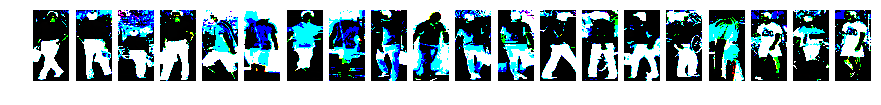

In [5]:
start = time.time()
batch = data.batch_generator(train_dict, P=P_param, K=K_param, preprocess=True,
                                    shape=(256,128)).next()
print time.time() - start

i = 0

plt.figure(figsize=(15,2))
for j in range(P_param*K_param):
    plt.subplot(1,20,j+1)
    im = batch[0][i][j].squeeze().astype(np.uint8)
#         print im.min(), im.max()
    plt.imshow(im)
    plt.axis('off')
plt.show()

### Define Learning Rate Schedule

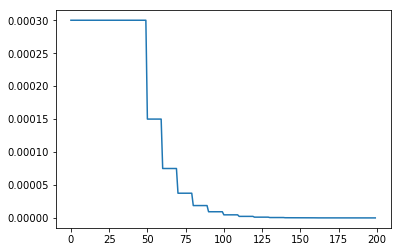

In [6]:
epochs = 10
steps_per_epoch = 100

lr = []
for era in range(1,21):
    for j in range(10):
        lr.append(training.step_decay_cont(epochs, era)(j))
plt.plot(np.arange(200), lr)

### Define Model

In [7]:
model = models.DenseNetDrop(P_param=P_param, K_param=K_param, weights='imagenet')

[-1, 0, 1, 2, 3]
[-1, 0, 1, 2, 3]
Weights for the model were loaded successfully
0.2
(20, 128)
(20, 128)
(20, 128)


In [8]:
# During evaluation, weights from model are loaded onto model_eval
model_eval = models.DenseNetDrop()

[-1, 0, 1, 2, 3]
[-1, 0, 1, 2, 3]
0.2
(1, 128)
(1, 128)
(1, 128)


In [ ]:
# model.summary()

In [ ]:
history = History()
for era in range(1,16):
    iterations = era * epochs * steps_per_epoch
    lrate = LearningRateScheduler(training.step_decay_cont(epochs, era))

    print 'era, ' + str(era)

    model.fit_generator(data.batch_generator(train_dict, P=P_param, K=K_param,
                            preprocess=True, shape=(256,128)),
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate,history])

    path = training.save_weights(model, it=iterations, root='vbranch_P5K4')
    model_eval.set_weights(model.get_weights())

    print evaluation.get_score(model_eval, hist=history, inputs=1)